In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from transformers import DeiTForImageClassification, AutoImageProcessor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# --- data (keep your ImageNet norm) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
print("class_to_idx:", train_dataset.class_to_idx)
num_classes = len(train_dataset.classes)

# --- model: load DeiT classifier model, but we'll use the backbone only ---
# (You can also use DeiTModel.from_pretrained(...) to skip heads entirely.)
processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224", weights_only=False)
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", weights_only=False).to(device)

# freeze everything
for p in model.parameters():
    p.requires_grad = False

# optional: make classifier a no-op so we don't accidentally use it
model.classifier = nn.Identity()

# backbone hidden size (CLS embedding)
hidden_dim = model.config.hidden_size  # 768 for base

@torch.no_grad()
def extract_deit_cls(model, imgs: torch.Tensor) -> torch.Tensor:
    """
    Get CLS embeddings from DeiT backbone.
    """
    out = model.deit(pixel_values=imgs, output_hidden_states=False, return_dict=True)
    cls = out.last_hidden_state[:, 0]  # (N, hidden_dim)
    return cls

# --- small trainable projection + center loss ---
proj_dim = 128
feat_proj = nn.Linear(hidden_dim, proj_dim).to(device)

class CenterLoss(nn.Module):
    def __init__(self, num_classes: int, feat_dim: int, device):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim, device=device))
    def forward(self, features: torch.Tensor, labels: torch.Tensor):
        # features: (N, D), labels: (N,) long
        centers_batch = self.centers[labels]
        return ((features - centers_batch) ** 2).sum() / (2.0 * features.size(0))

center_loss_fn = CenterLoss(num_classes=num_classes, feat_dim=proj_dim, device=device)

optimizer = optim.Adam([
    {"params": feat_proj.parameters(), "lr": 1e-3},
    {"params": center_loss_fn.parameters(), "lr": 5e-4},  # centers: smaller LR is typical
])

# --- train (center loss only) ---
def train_one_epoch():
    model.eval()        # backbone frozen
    feat_proj.train()
    running = 0.0

    for imgs, labels in tqdm(train_loader, desc="Training", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()  # (N,)

        with torch.set_grad_enabled(True):
            with torch.no_grad():
                feats_backbone = extract_deit_cls(model, imgs)  # (N, hidden_dim)
            feats = feat_proj(feats_backbone)                   # (N, proj_dim)
            loss = center_loss_fn(feats, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)

    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate_epoch():
    model.eval(); feat_proj.eval()
    correct = total = 0
    total_loss = 0.0
    centers = center_loss_fn.centers  # (C, D)

    for imgs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        feats = feat_proj(extract_deit_cls(model, imgs))        # (N, D)
        total_loss += center_loss_fn(feats, y).item() * imgs.size(0)

        # nearest-center classification (L2)
        dists = torch.cdist(feats, centers)                     # (N, C)
        preds = torch.argmin(dists, dim=1)                      # (N,)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total

class_to_idx: {'Negative': 0, 'Positive': 1}


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# --- loop ---
epochs = 10
for epoch in range(epochs):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate_epoch()
    print(f"Epoch {epoch+1}/{epochs} | train_center {tr_loss:.4f} | val_center {val_loss:.4f} | acc_nc {acc:.3f}")


Epoch 1/10 | train_center 40.7876 | val_center 26.1149 | acc_nc 0.802


Epoch 2/10 | train_center 22.6816 | val_center 20.3346 | acc_nc 0.816


Epoch 3/10 | train_center 18.5942 | val_center 17.9957 | acc_nc 0.839


Epoch 4/10 | train_center 16.5412 | val_center 16.6777 | acc_nc 0.848


Epoch 5/10 | train_center 15.3961 | val_center 15.8148 | acc_nc 0.848


Epoch 6/10 | train_center 14.4468 | val_center 15.1751 | acc_nc 0.857


Epoch 7/10 | train_center 13.6923 | val_center 14.7462 | acc_nc 0.866


Epoch 8/10 | train_center 13.0089 | val_center 14.5943 | acc_nc 0.871


Epoch 9/10 | train_center 12.5299 | val_center 13.8827 | acc_nc 0.862


Epoch 10/10 | train_center 12.1116 | val_center 13.5934 | acc_nc 0.866


              precision    recall  f1-score   support

    Negative     0.9000    0.9172    0.9085       157
    Positive     0.7719    0.7333    0.7521        60

    accuracy                         0.8664       217
   macro avg     0.8360    0.8253    0.8303       217
weighted avg     0.8646    0.8664    0.8653       217

Confusion Matrix:
 [[144  13]
 [ 16  44]]


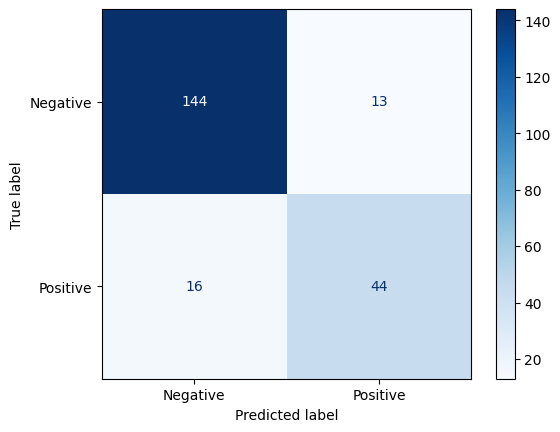

In [5]:

# --- sklearn metrics (nearest-center) ---
@torch.no_grad()
def collect_preds_center():
    model.eval(); feat_proj.eval()
    y_true, y_pred = [], []
    centers = center_loss_fn.centers
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = feat_proj(extract_deit_cls(model, imgs))
        dists = torch.cdist(feats, centers)
        preds = torch.argmin(dists, dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds_center()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot(cmap="Blues")
plt.show()
